In [11]:
import xarray as xr
import pandas as pd

from pathlib import Path
from scipy.ndimage import label

import sys, os, re
import numpy as np      
from netCDF4 import Dataset    
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt                         

import cartopy.crs as ccrs                              
import cartopy.feature as cfeature         
import cartopy.io.shapereader as shpreader 

from matplotlib.colors import ListedColormap, BoundaryNorm

# WS extent

In [13]:
CONTEXT_LAT_MIN = 5
CONTEXT_LAT_MAX = 20
CONTEXT_LON_MIN = -20
CONTEXT_LON_MAX = -4

# Load core

In [3]:
def load_core(t):

    year   = int(t["year"])
    month  = f"{int(t['month']):02d}"
    day    = f"{int(t['day']):02d}"
    hour   = f"{int(t['hour']):02d}"
    minute = f"{int(t['minute']):02d}"

    if year <= 2024:

        base = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{year}/{month}"
        fname = f"{year}{month}{day}{hour}{minute}.nc"
        path = os.path.join(base, fname)

        with Dataset(path) as ds:
            cores = ds["cores"][0]

            Pmax_lat = ds["max_lat"][:]
            Pmax_lon = ds["max_lon"][:]

        geo = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
        lons = geo["lon"]
        lats = geo["lat"]

    else:

        base = f"/gws/ssde/j25b/swift/rt_cores/{year}/{month}/{day}/{hour}{minute}"
        fname = f"Convective_struct_extended_{year}{month}{day}{hour}{minute}_000.nc"
        path = os.path.join(base, fname)

        with Dataset(path) as ds:
            cores = ds["cores"][:]

            Pmax_lat = ds["Pmax_lat"][:]
            Pmax_lon = ds["Pmax_lon"][:]

        geo = Dataset(
            "/gws/ssde/j25b/swift/rt_cores/geoloc_grids/"
            "nxny2268_2080_nxnyds164580_blobdx0.04491576_arean41_n27_27_79.nc"
        )
        lons = geo["lons_mid"][:]
        lats = geo["lats_mid"][:]
        geo.close()

    # ensure 1D arrays for matching
    Pmax_lat = np.asarray(Pmax_lat).ravel()
    Pmax_lon = np.asarray(Pmax_lon).ravel()

    return cores, lats, lons, Pmax_lat, Pmax_lon

# Load RDT

In [21]:
def load_rdt(t, domain="WestAfrica"):

    year   = int(t["year"])
    month  = f"{int(t['month']):02d}"
    day    = f"{int(t['day']):02d}"
    hour   = f"{int(t['hour']):02d}"
    minute = f"{int(t['minute']):02d}"

    base = Path("/gws/ssde/j25b/swift/earajr/NWCSAF_archive/netcdf_2018/RDT")

    date = f"{year}{month}{day}"
    time = f"{hour}{minute}00"

    fname = f"S_NWC_RDT-CW_MSG4_{domain}-VISIR_{date}T{time}Z.nc"
    path = base / date / fname

    if not path.exists():
        return None, None, None, None

    with Dataset(path) as ds:

        rdt = {k: ds[k][:] for k in ds.variables}

        cat = ds["MapCellCatType"][:]
        lat = ds["lat"][:]
        lon = ds["lon"][:]

    return rdt, cat, lat, lon

# Load both data

In [22]:
t = dict(year=2021, month=4, day=24, hour=22, minute=15)

data_core, lats_core, lons_core, Pmax_lat, Pmax_lon = load_core(t)
data_rdt, data_cat, lats_rdt, lons_rdt = load_rdt(t)

# Plotting and overlay

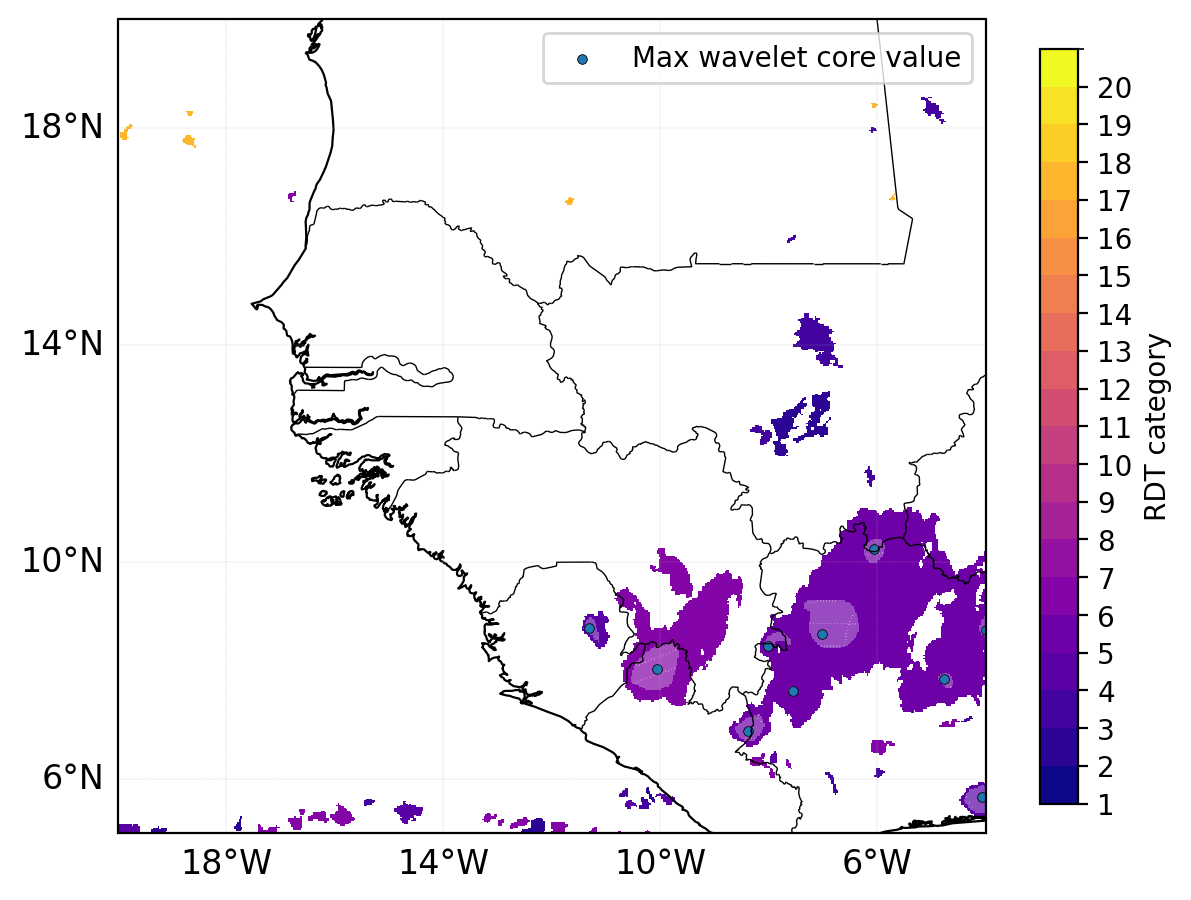

In [33]:
mask_rdt  = np.where(data_cat > 0, data_cat, np.nan)
mask_core = np.where(data_core > 0, 1, np.nan)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7, 7), dpi=200)
ax = plt.axes(projection=proj)

ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

ax.set_extent(
    [CONTEXT_LON_MIN, CONTEXT_LON_MAX,
     CONTEXT_LAT_MIN, CONTEXT_LAT_MAX],
    crs=proj
)

gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.1, 
                    xlocs=np.arange(-18, 6, 4),
                    ylocs=np.arange(6, 20, 4)
                    )

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}


levels = np.arange(1, int(np.nanmax(data_cat)) + 2)
cmap = ListedColormap(plt.cm.plasma(np.linspace(0, 1, len(levels)-1)))
norm = BoundaryNorm(levels, cmap.N)

im = ax.pcolormesh(
    lons_rdt,
    lats_rdt,
    mask_rdt,
    shading="nearest",
    cmap=cmap,
    norm=norm,
    transform=proj
)

ax.pcolormesh(
    lons_core,
    lats_core,
    mask_core,
    shading="nearest",
    alpha=0.3,
    cmap="Greys",
    transform=proj
)

ax.scatter(
    Pmax_lon,
    Pmax_lat,
    s=12,
    marker="o",
    color="tab:blue",
    edgecolors="black",
    linewidths=0.3,
    label="Max wavelet core value",
    transform=proj
)

cbar = plt.colorbar(
    im,
    ax=ax,
    ticks=levels[:-1],
    shrink=0.7,
    pad=0.05
)

cbar.set_label("RDT category")

ax.legend(loc="upper right")

plt.show()


# Object extraction

## RDT

In [19]:
def rdt_to_dataframe(rdt):

    if rdt is None:
        return pd.DataFrame()

    cat = rdt["MapCellCatType"]
    lat_grid = rdt["lat"]
    lon_grid = rdt["lon"]

    mask = cat > 0

    labels, n = label(mask)

    if n == 0:
        return pd.DataFrame()

    R = 6371.0

    lat_rad = np.deg2rad(lat_grid)
    lon_rad = np.deg2rad(lon_grid)

    dlat = np.gradient(lat_rad, axis=0)
    dlon = np.gradient(lon_rad, axis=1)

    dy = R * dlat
    dx = R * np.cos(lat_rad) * dlon

    pixel_area = np.abs(dx * dy)

    rows = []

    for lab in range(1, n + 1):

        ys, xs = np.where(labels == lab)

        area = pixel_area[ys, xs].sum()
        lat_c = lat_grid[ys, xs].mean()
        lon_c = lon_grid[ys, xs].mean()

        # dominant category
        vals = cat[ys, xs]
        cat_type = np.bincount(vals.astype(int)).argmax()

        rows.append((lab, lat_c, lon_c, area, cat_type))

    df = pd.DataFrame(
        rows,
        columns=["cell_id", "lat", "lon", "size_km2", "cat_type"]
    )

    return df


In [17]:
df_rdt = rdt_to_dataframe(rdt)

In [18]:
df_rdt

,cell_id,lat,lon,size_km2,cat_type
0,1,37.050243,-4.369785,639.912964,4
1,2,37.163063,-13.693691,365.163086,3
2,3,37.123009,-10.705098,137.333328,3
3,4,37.044846,-14.004734,519.621155,3
4,5,36.645824,-13.831018,556.049255,3
...,...,...,...,...,...
477,478,0.989388,0.045957,551.760681,3
478,479,1.173059,1.677878,162.957001,6
479,480,1.169234,3.668723,136.195847,6
480,481,1.090129,1.795479,217.289551,6


# Core yx bounds for Western Sahel

In [ ]:
y_min, y_max = 1403, 1914
x_min, x_max = 66, 577

cores = cores[y_min:y_max+1, x_min:x_max+1]
lats_data = core_datay_min:y_max+1, x_min:x_max+1]
core_lats  = core_lons[y_min:y_max+1, x_min:x_max+1]

# Area map

In [ ]:
R = 6371.0  # km

lat_rad = np.deg2rad(lats)
core_
dlat = np.abs(np.gradient(lat_rad, axis=0))
dlon = np.abs(np.gradient(np.deg2rad(lons), axis=1))
core_
pixel_area = (R**2) * dlat * dlon * np.cos(lat_rad)

# KD-tree to get yx later

In [ ]:
Ny, Nx = lats.shape
core_
grid_points = np.column_stack([
    lats.ravel(),
    core_lons.ravel()
])

grid_tree = cKDTree(grid_points)

In [12]:
def latlon_to_yx(lat, lon):
    _, flat = grid_tree.query([lat, lon])
    return np.unravel_index(flat, (Ny, Nx))

In [13]:
def create_storm_database(
    cores, lats, lons,
    Pmax_lat, Pmax_lon,
    CONTEXT_LAT_MIN, CONTEXT_LAT_MAX,
    CONTEXT_LON_MIN, CONTEXT_LON_MAX
):

    if not np.any(cores):
        return {}

    valid = (
        (Pmax_lon >= CONTEXT_LON_MIN) & (Pmax_lon <= CONTEXT_LON_MAX) &
        (Pmax_lat >= CONTEXT_LAT_MIN) & (Pmax_lat <= CONTEXT_LAT_MAX)
    )

    Pmax_lat = Pmax_lat[valid]
    Pmax_lon = Pmax_lon[valid]

    labeled_array, _ = label(cores != 0)

    storm_database = {}

    for lab in np.unique(labeled_array):
        if lab == 0:
            continue

        ys, xs = np.where(labeled_array == lab)

        size_km2  = float(np.sum(pixel_area[ys, xs]))
        intensity = float(np.nanmean(cores[ys, xs]))

        lat_min = float(lats[ys.min(), xs.min()])
        lat_max = float(lats[ys.max(), xs.max()])
        lon_min = float(lons[ys.min(), xs.min()])
        lon_max = float(lons[ys.max(), xs.max()])

        for lat, lon in zip(Pmax_lat, Pmax_lon):

            y_idx, x_idx = latlon_to_yx(lat, lon)

            if labeled_array[y_idx, x_idx] != lab:
                continue

            storm_database[int(lab)] = {
                "lat": float(lat),
                "lon": float(lon),
                "lat_min": lat_min,
                "lat_max": lat_max,
                "lon_min": lon_min,
                "lon_max": lon_max,
                "wp": intensity,
                "size": size_km2
            }

            break

    return storm_database

# Creating core database

In [ ]:
core_db = create_storm_database(
            cores, lats, lons,
            Pmax_datalacore_tcore_, Pmax_lon,
            CONTEXT_LAT_MIN, CONTEXT_LAT_MAX,
            CONTEXT_LON_MIN, CONTEXT_LON_MAX
)

df_core = pd.DataFrame.from_dict(core_db, orient="index").reset_index(names="label")